## 作業 : (Kaggle)鐵達尼生存預測  

### [作業目標]
- 試著模仿範例寫法, 在鐵達尼生存預測中, 練習特徵重要性的寫作與觀察  

### [作業重點]
- 仿造範例, 完成特徵重要性的計算, 並觀察對預測結果的影響
- 仿造範例, 將兩個特徵重要性最高的特徵重組出新特徵, 並觀察對預測結果的影響

In [1]:
import pandas as pd
import numpy as np
import copy
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("titanic_train.csv")

train_Y = df["Survived"]
df = df.drop(["PassengerId", "Survived"], axis=1)
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
# 因為需要把類別型與數值型特徵都加入, 故使用最簡版的特徵工程
LEncoder = LabelEncoder()
MMEncoder = MinMaxScaler()
for c in df.columns:
    df[c] = df[c].fillna(-1)
    if df[c].dtype == "object":
        df[c] = LEncoder.fit_transform(list(df[c].values))
    df[c] = MMEncoder.fit_transform(df[c].values.reshape(-1, 1))
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1.0,0.121348,1.0,0.283951,0.125,0.0,0.769118,0.014151,0.000000,1.000000
1,0.0,0.213483,0.0,0.481481,0.125,0.0,0.876471,0.139136,0.557823,0.333333
2,1.0,0.396629,0.0,0.333333,0.000,0.0,0.983824,0.015469,0.000000,1.000000
3,0.0,0.305618,0.0,0.444444,0.125,0.0,0.072059,0.103644,0.380952,1.000000
4,1.0,0.016854,1.0,0.444444,0.000,0.0,0.694118,0.015713,0.000000,1.000000


In [3]:
# 隨機森林擬合後, 將結果依照重要性由高到低排序
estimator = RandomForestClassifier()
estimator.fit(df.values, train_Y)
feats = pd.Series(data=estimator.feature_importances_, index=df.columns)
feats = feats.sort_values(ascending=False)
feats

Sex         0.245168
Ticket      0.158336
Name        0.140992
Fare        0.132495
Age         0.112505
Cabin       0.070249
Pclass      0.060342
Parch       0.030465
SibSp       0.027382
Embarked    0.022066
dtype: float64

## 先用隨機森林對鐵達尼生存預測做訓練，再用其特徵重要性回答下列問題

## 作業1
- 將特徵重要性較低的一半特徵刪除後，再做生存率預估，正確率是否有變化?

In [4]:
# 原始特徵 + 隨機森林
train_X = MMEncoder.fit_transform(df)
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.8395204318624068

In [5]:
# 高重要性特徵(前一半) + 隨機森林
high_feature = list(feats[:5].index)
train_X = MMEncoder.fit_transform(df[high_feature])
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.8193019898311468

In [6]:
# 高重要性特徵(前2/3) + 隨機森林
high_feature = list(feats[:7].index)
train_X = MMEncoder.fit_transform(df[high_feature])
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.8417738999435063

- <font color=#0000FF>使用重要性特徵的準確度可能有高有低(取決於篩選多少特徵)</font>
- <font color=#0000FF>若只使用一半的特徵, 表示高重要特徵的資訊密度是高的, 使用較少特徵, 泛化能力(對外部資料預測力)也會提升</font>

## 作業2
- 將特徵重要性最高的兩個特徵做特徵組合，是否能再進一步提升預測力?

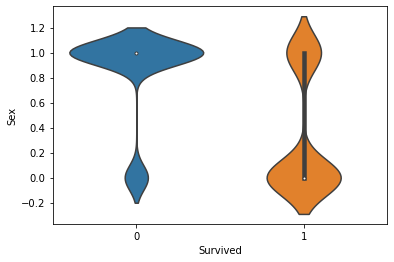

In [7]:
# 觀察重要特徵與目標的分布
# 第一名              
import seaborn as sns
import matplotlib.pyplot as plt
sns.violinplot(x=train_Y, y=df["Sex"], fit_reg=False)
plt.show()

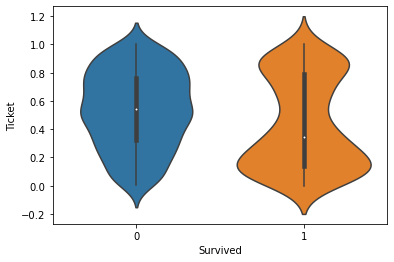

In [8]:
# 第二名       
sns.violinplot(x=train_Y, y=df["Ticket"], fit_reg=False)
plt.show()

In [9]:
# 製作新特徵看效果
df["Add_char"] = (df["Sex"] + df["Ticket"]) / 2
df["Multi_char"] = df["Sex"] * df["Ticket"]
train_X = MMEncoder.fit_transform(df)
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.8327914129684263

- <font color=#0000FF>做特徵組合後的準確度是否提升, 具有隨機性(每次跑的結果不同)</font>